In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import itertools

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load dataset
data = np.load('/content/ORL_faces.npz')

# Load the "Train Images"
x_data = data['trainX']
x_data = np.array(x_data, dtype='float32') / 255

y_data = data['trainY']

# Reshape images to include channel dimension
im_rows, im_cols = 112, 92
im_shape = (im_rows, im_cols, 1)
x_data = x_data.reshape(x_data.shape[0], *im_shape)

# Split the data into train, validation, and test sets using stratification
x_temp, x_test, y_temp, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=y_data, random_state=1234)
x_train, x_valid, y_train, y_valid = train_test_split(x_temp, y_temp, test_size=0.1, stratify=y_temp, random_state=1234)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_valid shape:', x_valid.shape)
print('y_valid shape:', y_valid.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


x_train shape: (172, 112, 92, 1)
y_train shape: (172,)
x_valid shape: (20, 112, 92, 1)
y_valid shape: (20,)
x_test shape: (48, 112, 92, 1)
y_test shape: (48,)


In [ ]:
def create_pairs(x, y):
    pairs = []
    labels = []
    n_classes = np.max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(n_classes)]

    for idx1 in range(len(x)):
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = np.random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        label2 = (label1 + np.random.randint(1, n_classes)) % n_classes
        idx2 = np.random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels)

train_pairs, train_labels = create_pairs(x_train, y_train)
valid_pairs, valid_labels = create_pairs(x_valid, y_valid)
test_pairs, test_labels = create_pairs(x_test, y_test)

print('train_pairs shape:', train_pairs.shape)
print('train_labels shape:', train_labels.shape)


train_pairs shape: (344, 2, 112, 92, 1)
train_labels shape: (344,)


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from keras import backend as K
from keras.optimizers import Adam

def build_base_network(input_shape):
    model = Sequential([
        Conv2D(64, (10, 10), activation='relu', input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(128, (7, 7), activation='relu'),
        MaxPooling2D(),
        Conv2D(128, (4, 4), activation='relu'),
        MaxPooling2D(),
        Conv2D(256, (4, 4), activation='relu'),
        Flatten(),
        Dense(4096, activation='sigmoid')
    ])
    return model

def euclidean_distance(vectors):
    x, y = vectors
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def euclidean_distance_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

input_shape = (im_rows, im_cols, 1)
base_network = build_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=euclidean_distance_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 92, 1)]         0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 112, 92, 1)]         0         []                            
                                                                                                  
 sequential (Sequential)     (None, 4096)                 2636473   ['input_1[0][0]',             
                                                          6          'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['sequential[0][0]',      

In [ ]:
history = model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]], train_labels,
    batch_size=128,
    epochs=50,
    validation_data=([valid_pairs[:, 0], valid_pairs[:, 1]], valid_labels)
)


Epoch 1/50
3/3 [==============================] - 103s 28s/step - loss: 1.6786 - accuracy: 0.5000 - val_loss: 4.1289 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 89s 28s/step - loss: 1.3985 - accuracy: 0.5029 - val_loss: 4.2531 - val_accuracy: 0.4500
Epoch 3/50
3/3 [==============================] - 87s 28s/step - loss: 1.2858 - accuracy: 0.4390 - val_loss: 4.4079 - val_accuracy: 0.2500
Epoch 4/50
3/3 [==============================] - 87s 29s/step - loss: 1.2579 - accuracy: 0.3692 - val_loss: 4.3415 - val_accuracy: 0.3500
Epoch 5/50
3/3 [==============================] - 84s 27s/step - loss: 1.1992 - accuracy: 0.4884 - val_loss: 4.2847 - val_accuracy: 0.4500
Epoch 6/50
3/3 [==============================] - 85s 26s/step - loss: 1.1842 - accuracy: 0.5262 - val_loss: 4.2834 - val_accuracy: 0.4250
Epoch 7/50
3/3 [==============================] - 87s 26s/step - loss: 1.1686 - accuracy: 0.5581 - val_loss: 4.2980 - val_accuracy: 0.3750
Epoch 8/50
3/3 [==========

3/3 [==============================] - 6s 2s/step - loss: 2.2895 - accuracy: 0.3542
Test loss: 2.289533853530884
Test accuracy: 0.3541666567325592


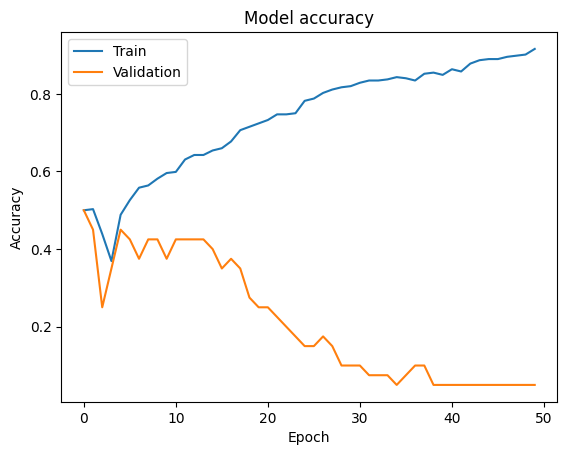

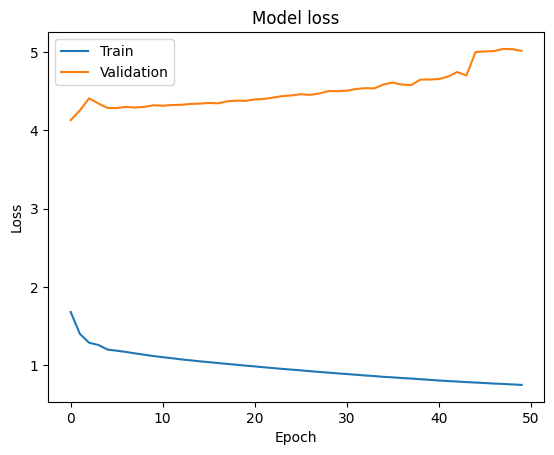

In [ ]:
score = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training history
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
model.save('siamese_network_face_recognition_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 7s 2s/step
Loaded model accuracy: 0.6458333333333334
Confusion matrix, without normalization


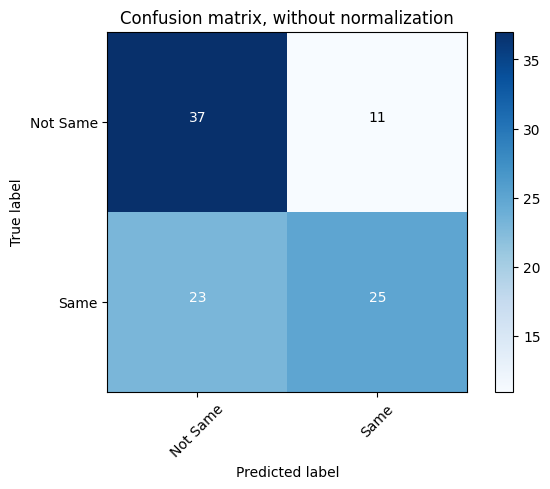

              precision    recall  f1-score   support

           0       0.62      0.77      0.69        48
           1       0.69      0.52      0.60        48

    accuracy                           0.65        96
   macro avg       0.66      0.65      0.64        96
weighted avg       0.66      0.65      0.64        96



In [ ]:
from keras.models import load_model

# Load the trained model
loaded_model = load_model('siamese_network_face_recognition_model.h5', custom_objects={'euclidean_distance': euclidean_distance, 'euclidean_distance_output_shape': euclidean_distance_output_shape})

# Use the loaded model to make predictions
test_distance = loaded_model.predict([test_pairs[:, 0], test_pairs[:, 1]])
y_pred = (test_distance < 0.5).astype(int).reshape(-1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print("Loaded model accuracy:", accuracy)

# Confusion matrix and classification report
cnf_matrix = confusion_matrix(test_labels, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Not Same', 'Same'], title='Confusion matrix, without normalization')
plt.show()

# Print classification report
print(classification_report(test_labels, y_pred))
